In [6]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import zscore
from scipy.signal import detrend
from scipy.ndimage import gaussian_filter1d
import time
import gc
import copy

def smooth_with_gaussian(data, sigma=3):
    return gaussian_filter1d(data, sigma=sigma, axis=1) 

file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]
structure = {f'dataset_{file_number}': {
    'left_attleft': [],
    'right_attleft': [],
    'left_attright': [],
    'right_attright': []
} for file_number in file_numbers}

pearson_results_raw = copy.deepcopy(structure)
pearson_errors_raw = copy.deepcopy(structure)

pearson_results_nopre = copy.deepcopy(structure)
pearson_errors_nopre = copy.deepcopy(structure)


total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    left_input_SP = data['SP'][0][0] 
    right_input_SP = data['SP'][0][1]
    attention_SP = data['SP'][0][2]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    # left_input_SP (2032, 500, 160)
    # right_input_SP (2032, 500, 160)
    # attention_SP (2032, 500, 80)
    

    # attend_left_not_omitted = np.where((data["attend"][0] == 0) & (data["omit"][0] == 0) & (label_left != label_right))[0]
    # attend_right_not_omitted = np.where((data["attend"][0] == 1) & (data["omit"][0] == 0) & (label_left != label_right))[0]

    attend_left_not_omitted = np.where((data["attend"][0] == 0) & (data["omit"][0] == 0))[0]
    attend_right_not_omitted = np.where((data["attend"][0] == 1) & (data["omit"][0] == 0))[0]

    left_input_attendingleft_t = left_input_SP[attend_left_not_omitted, 100:350, :]
    right_input_attendingleft_t = right_input_SP[attend_left_not_omitted, 100:350, :]
    attention_layer_attendingleft_t = attention_SP[attend_left_not_omitted, 100:350, :]

    left_input_attendingright_t = left_input_SP[attend_right_not_omitted, 100:350, :]
    right_input_attendingright_t = right_input_SP[attend_right_not_omitted, 100:350, :]
    attention_layer_attendingright_t = attention_SP[attend_right_not_omitted, 100:350, :]

    #eft_input_attendingleft_t (468, 250, 160) (80 for attention)
    #left_input_attendingright_t (536, 250, 160) (80 for attention)

    sigma = 2

    left_in_attleft_sm = smooth_with_gaussian(left_input_attendingleft_t, sigma=sigma) 
    right_in_attleft_sm = smooth_with_gaussian(right_input_attendingleft_t, sigma=sigma) 
    attlay_attleft_sm = smooth_with_gaussian(attention_layer_attendingleft_t, sigma=sigma) 

    left_in_attright_sm = smooth_with_gaussian(left_input_attendingright_t, sigma=sigma) 
    right_in_attright_sm = smooth_with_gaussian(right_input_attendingright_t, sigma=sigma)
    attlay_attright_sm = smooth_with_gaussian(attention_layer_attendingright_t, sigma=sigma)


    num_trials_left, num_samples, num_neurons_left = left_input_attendingleft_t.shape
    num_trials_right = left_input_attendingright_t.shape[0]
    num_neurons_attention = 80

            
    for j in range(0, num_trials_left):
        for i in range(0, num_neurons_left):
            count_left = np.count_nonzero(left_input_attendingleft_t[j, :, i] == 1)
            if count_left > 0:
                left_in_attleft_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_attendingleft_t[j, :, i] == 1)
            if count_right > 0:
                right_in_attleft_sm[j, :, i] /= count_right


        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_layer_attendingleft_t[j, :, i] == 1)
            if count_attention > 0:
                attlay_attleft_sm[j, :, i] /= count_attention



    for j in range(0, num_trials_right):
        for i in range(0, num_neurons_left):
            count_left = np.count_nonzero(left_input_attendingright_t[j, :, i] == 1)
            if count_left > 0:
                left_in_attright_sm[j, :, i] /= count_left
            count_right = np.count_nonzero(right_input_attendingright_t[j, :, i] == 1)
            if count_right > 0:
                right_in_attright_sm[j, :, i] /= count_right    

        for i in range(0, num_neurons_attention):
            count_attention = np.count_nonzero(attention_layer_attendingright_t[j, :, i] == 1)
            if count_attention > 0:
                attlay_attright_sm[j, :, i] /= count_attention


    left_input_SP_attleft = np.sum(left_in_attleft_sm, axis=2)
    right_input_SP_attleft = np.sum(right_in_attleft_sm, axis=2)
    attention_SP_attleft = np.sum(attlay_attleft_sm, axis=2)

    left_input_SP_attright = np.sum(left_in_attright_sm, axis=2)
    right_input_SP_attright = np.sum(right_in_attright_sm, axis=2)
    attention_SP_attright = np.sum(attlay_attright_sm, axis=2)

    #plt.plot(left_input_SP_attleft[0])
    #plt.show()

    #----------------no preprocessing--------------------------------
    left_attleft_pearson = []
    right_attleft_pearson = []
    left_attright_pearson = []
    right_attright_pearson = []

    for i in range(len(left_input_SP_attleft)):
        left_attleft_pearson.append(pearsonr(left_input_SP_attleft[i], attention_SP_attleft[i])[0])
        right_attleft_pearson.append(pearsonr(right_input_SP_attleft[i], attention_SP_attleft[i])[0])

    for i in range(len(left_input_SP_attright)):
        left_attright_pearson.append(pearsonr(left_input_SP_attright[i], attention_SP_attright[i])[0])
        right_attright_pearson.append(pearsonr(right_input_SP_attright[i], attention_SP_attright[i])[0])
    
    mean_left_attleft = np.mean(left_attleft_pearson)
    mean_right_attleft = np.mean(right_attleft_pearson)
    mean_left_attright = np.mean(left_attright_pearson)
    mean_right_attright = np.mean(right_attright_pearson)

    std_left_attleft = np.std(left_attleft_pearson)
    std_right_attleft = np.std(right_attleft_pearson)
    std_left_attright = np.std(left_attright_pearson)
    std_right_attright = np.std(right_attright_pearson)

    sem_left_attleft = std_left_attleft / np.sqrt(len(left_attleft_pearson))
    sem_right_attleft = std_right_attleft / np.sqrt(len(right_attleft_pearson))
    sem_left_attright = std_left_attright / np.sqrt(len(left_attright_pearson))
    sem_right_attright = std_right_attright / np.sqrt(len(right_attright_pearson))
    
    pearson_results_nopre[f'dataset_{file_number}']['left_attleft'] = (mean_left_attleft)
    pearson_results_nopre[f'dataset_{file_number}']['right_attleft'] = (mean_right_attleft)
    pearson_results_nopre[f'dataset_{file_number}']['left_attright'] = (mean_left_attright)
    pearson_results_nopre[f'dataset_{file_number}']['right_attright'] = (mean_right_attright)

    pearson_errors_nopre[f'dataset_{file_number}']['left_attleft'] = (sem_left_attleft)
    pearson_errors_nopre[f'dataset_{file_number}']['right_attleft'] = (sem_right_attleft)
    pearson_errors_nopre[f'dataset_{file_number}']['left_attright'] = (sem_left_attright)
    pearson_errors_nopre[f'dataset_{file_number}']['right_attright'] = (sem_right_attright)

    
    #---------------- preprocessing the data ----------------------------------------NB detrending first to avoid 0 and NaN values
    if len(attend_left_not_omitted) >= 1:
        left_input_SP_attleft = detrend(left_input_SP_attleft, axis=0)
        right_input_SP_attleft = detrend(right_input_SP_attleft, axis=0)
        attention_SP_attleft = detrend(attention_SP_attleft, axis=0)

    if len(attend_right_not_omitted) >= 1:
        left_input_SP_attright = detrend(left_input_SP_attright, axis=0)
        right_input_SP_attright = detrend(right_input_SP_attright, axis=0)
        attention_SP_attright = detrend(attention_SP_attright, axis=0)

    for i in range(len(left_input_SP_attleft)):
        left_input_SP_attleft[i] = detrend(left_input_SP_attleft[i])
        right_input_SP_attleft[i] = detrend(right_input_SP_attleft[i])
        attention_SP_attleft[i] = detrend(attention_SP_attleft[i])

    for i in range(len(left_input_SP_attright)):
        left_input_SP_attright[i] = detrend(left_input_SP_attright[i])
        right_input_SP_attright[i] = detrend(right_input_SP_attright[i])
        attention_SP_attright[i] = detrend(attention_SP_attright[i])

    if len(attend_left_not_omitted) >= 2:
        left_input_SP_attleft = zscore(left_input_SP_attleft, axis=0)
        right_input_SP_attleft = zscore(right_input_SP_attleft, axis=0)
        attention_SP_attleft = zscore(attention_SP_attleft, axis=0)

    if len(attend_right_not_omitted) >= 2:
        left_input_SP_attright = zscore(left_input_SP_attright, axis=0)
        right_input_SP_attright = zscore(right_input_SP_attright, axis=0)
        attention_SP_attright = zscore(attention_SP_attright, axis=0)

    #plt.plot(left_input_SP_attleft[0])
    #plt.show()


    #----------------------------------------------------------------
    left_attleft_pearson = []
    right_attleft_pearson = []
    left_attright_pearson = []
    right_attright_pearson = []

    for i in range(len(left_input_SP_attleft)):
        left_attleft_pearson.append(pearsonr(left_input_SP_attleft[i], attention_SP_attleft[i])[0])
        right_attleft_pearson.append(pearsonr(right_input_SP_attleft[i], attention_SP_attleft[i])[0])

    for i in range(len(left_input_SP_attright)):
        left_attright_pearson.append(pearsonr(left_input_SP_attright[i], attention_SP_attright[i])[0])
        right_attright_pearson.append(pearsonr(right_input_SP_attright[i], attention_SP_attright[i])[0])
    
    mean_left_attleft = np.mean(left_attleft_pearson)
    mean_right_attleft = np.mean(right_attleft_pearson)
    mean_left_attright = np.mean(left_attright_pearson)
    mean_right_attright = np.mean(right_attright_pearson)

    std_left_attleft = np.std(left_attleft_pearson)
    std_right_attleft = np.std(right_attleft_pearson)
    std_left_attright = np.std(left_attright_pearson)
    std_right_attright = np.std(right_attright_pearson)

    sem_left_attleft = std_left_attleft / np.sqrt(len(left_attleft_pearson))
    sem_right_attleft = std_right_attleft / np.sqrt(len(right_attleft_pearson))
    sem_left_attright = std_left_attright / np.sqrt(len(left_attright_pearson))
    sem_right_attright = std_right_attright / np.sqrt(len(right_attright_pearson))

    #-------storing these means across trials into results dictionary-------------
    #have given resuylts left a dict for this right class, so =  to that class

    pearson_results_raw[f'dataset_{file_number}']['left_attleft'] = (mean_left_attleft)
    pearson_results_raw[f'dataset_{file_number}']['right_attleft'] = (mean_right_attleft)
    pearson_results_raw[f'dataset_{file_number}']['left_attright'] = (mean_left_attright)
    pearson_results_raw[f'dataset_{file_number}']['right_attright'] = (mean_right_attright)

    pearson_errors_raw[f'dataset_{file_number}']['left_attleft'] = (sem_left_attleft)
    pearson_errors_raw[f'dataset_{file_number}']['right_attleft'] = (sem_right_attleft)
    pearson_errors_raw[f'dataset_{file_number}']['left_attright'] = (sem_left_attright)
    pearson_errors_raw[f'dataset_{file_number}']['right_attright'] = (sem_right_attright)

    del left_input_SP_attleft, right_input_SP_attleft, attention_SP_attleft, left_input_SP_attright, right_input_SP_attright, attention_SP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)
print(pearson_results_raw)


Dataset 1 loaded in 15.00 seconds
Dataset 1 complete in 28.372163772583008
Dataset 2 loaded in 23.50 seconds
Dataset 2 complete in 34.20834445953369
Dataset 4 loaded in 12.26 seconds
Dataset 4 complete in 21.771915197372437
Dataset 8 loaded in 8.84 seconds
Dataset 8 complete in 18.39196515083313
Dataset 14 loaded in 10.61 seconds
Dataset 14 complete in 20.673527717590332
Dataset 15 loaded in 18.71 seconds
Dataset 15 complete in 28.815717697143555
Dataset 20 loaded in 9.25 seconds
Dataset 20 complete in 18.615630388259888
Dataset 23 loaded in 7.99 seconds
Dataset 23 complete in 19.68742346763611
total time elapsed = 190.58670592308044
{'dataset_1': {'left_attleft': np.float64(0.3601929222394909), 'right_attleft': np.float64(0.29222749525475683), 'left_attright': np.float64(0.30751802822304436), 'right_attright': np.float64(0.3302014874761116)}, 'dataset_2': {'left_attleft': np.float64(0.3890700785668942), 'right_attleft': np.float64(0.22674367719841423), 'left_attright': np.float64(0.37

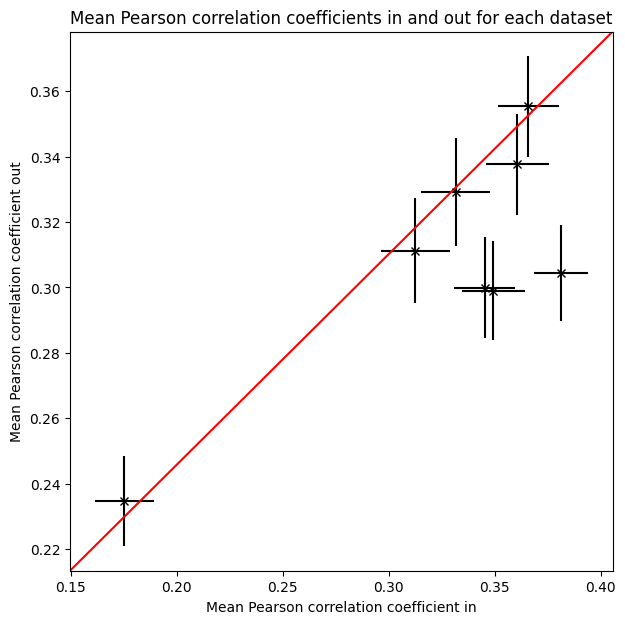

In [4]:

#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
pearson_in = []
pearson_out = []
errors_in = []
errors_out = []

for file_number in file_numbers:
    values = []
    errors = []
    for condition in ['left_attleft', 'right_attright']:
        values.append(pearson_results_raw[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors_raw[f'dataset_{file_number}'][condition])
    pearson_in.append(np.mean(values))
    errors_in.append(np.mean(errors))


    values = []
    errors = []
    for condition in ['left_attright', 'right_attleft']:
        values.append(pearson_results_raw[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors_raw[f'dataset_{file_number}'][condition])
    pearson_out.append(np.mean(values))
    errors_out.append(np.mean(errors))



plt.figure(figsize=(7,7))
plt.errorbar(pearson_in, pearson_out, xerr=errors_in, yerr=errors_out, fmt='x', color = 'k')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'r')
plt.xlabel('Mean Pearson correlation coefficient in')
plt.ylabel('Mean Pearson correlation coefficient out')
plt.title('Mean Pearson correlation coefficients in and out for each dataset')
plt.show()



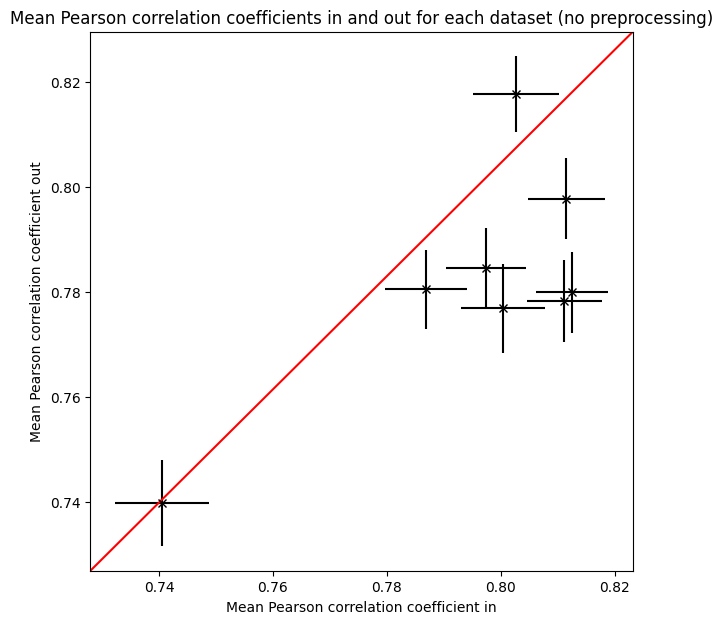

In [5]:

#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
pearson_in = []
pearson_out = []
errors_in = []
errors_out = []

for file_number in file_numbers:
    values = []
    errors = []
    for condition in ['left_attleft', 'right_attright']:
        values.append(pearson_results_nopre[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors_nopre[f'dataset_{file_number}'][condition])
    pearson_in.append(np.mean(values))
    errors_in.append(np.mean(errors))


    values = []
    errors = []
    for condition in ['left_attright', 'right_attleft']:
        values.append(pearson_results_nopre[f'dataset_{file_number}'][condition])
        errors.append(pearson_errors_nopre[f'dataset_{file_number}'][condition])
    pearson_out.append(np.mean(values))
    errors_out.append(np.mean(errors))



plt.figure(figsize=(7,7))
plt.errorbar(pearson_in, pearson_out, xerr=errors_in, yerr=errors_out, fmt='x', color = 'k')
plt.plot([0, 1], [0, 1], transform=plt.gca().transAxes, color = 'r')
plt.xlabel('Mean Pearson correlation coefficient in')
plt.ylabel('Mean Pearson correlation coefficient out')
plt.title('Mean Pearson correlation coefficients in and out for each dataset (no preprocessing)')
plt.show()

